In [4]:
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the model
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** k3 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

#Define true parameters
true_params = np.array([
    0, 0, 0  # first set of odes
])

#Define the simulator!
def solve_ode(params, t):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    solution = odeint(model, initial_conditions, t, args=(params,))
    return solution

num_timesteps = 1000  # Number of time steps for simulation
t = np.linspace(0, 100, num_timesteps) #Range of time of simulation
true_data = solve_ode(true_params, t) #True trajectories

# epsilon = 150 NOT NEEDED Error threshold used in kernel, higher than 2 params
# num_samples = 10000 NOT NEEDED # Number of samples to draw



In [3]:
import torch

from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

num_dim = 3
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
batch_size = 1
num_trajectories = 6

def simulator(parameters):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameters,))
    traj = torch.zeros((num_trajectories, num_timesteps))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[i, timestep] = solution[timestep][i]
    return traj

true_data = simulator(true_params)

In [43]:
true_data

tensor([[  0.0000,   8.9123,  13.8703,  ...,  46.9959,  42.7398,  38.8630],
        [  1.0000,   1.3648,   2.3506,  ..., 113.7526, 107.1846, 100.8554],
        [  0.0000,  12.9051,  14.4150,  ...,  56.8882,  63.3755,  70.3635],
        [  3.0000,   3.4811,   4.4862,  ...,  25.9989,  29.2513,  32.8362],
        [  0.0000,  42.9083,  61.6269,  ...,   1.2610,   1.2439,   1.2295],
        [  2.0000,   4.0501,   8.8289,  ...,   2.7314,   2.5905,   2.4615]])

In [8]:
simulator, prior = prepare_for_sbi(simulator, prior)

In [9]:
inference = SNPE(prior=prior)

In [11]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

In [12]:
inference = inference.append_simulations(theta, x)

In [13]:
density_estimator = inference.train()

Neural network successfully converged after 114 epochs.


In [14]:
posterior = inference.build_posterior(density_estimator)

In [18]:
def simulator(parameters):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameters,))
    traj = torch.zeros((num_trajectories, num_timesteps))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[i, timestep] = solution[timestep][i]
    return traj

true_data = simulator(true_params)

In [44]:
true_list = []
for traj in true_data:
    for timepoint in traj:
        true_list.append(timepoint)
true_tensor = torch.Tensor(true_list)
true_tensor.shape

torch.Size([6000])

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

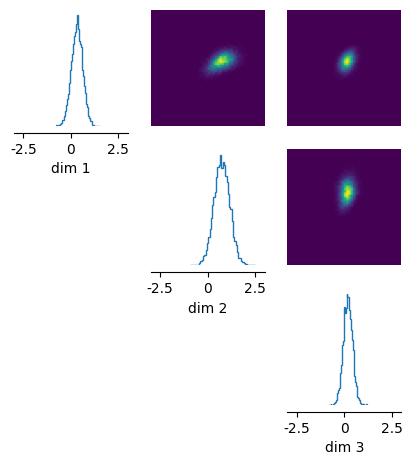

In [22]:
posterior_samples = posterior.sample((10000,), x=true_tensor)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-3, 3], [-3, 3], [-3, 3]], figsize=(5, 5)
)

In [29]:
#Try to run with 6 params, k and alpha:
# Define the model
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    a1, k1, a2, k2, a3, k3 = params

    dm1dt = -m1 + (10 ** a1 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** a2 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** a3 / (1 + (10 ** k3 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

#Define true parameters
true_params = np.array([
    3, 0, 3, 0, 3, 0  # first set of odes
])

#Define the simulator!
def solve_ode(params, t):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    solution = odeint(model, initial_conditions, t, args=(params,))
    return solution

num_timesteps = 1000  # Number of time steps for simulation
t = np.linspace(0, 100, num_timesteps) #Range of time of simulation
true_data = solve_ode(true_params, t) #True trajectories

In [30]:
import torch

from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

num_dim = 6
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
batch_size = 1
num_trajectories = 6

def simulator(parameters):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameters,))
    traj = torch.zeros((num_trajectories, num_timesteps))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[i, timestep] = solution[timestep][i]
    return traj

true_data = simulator(true_params)

In [31]:
simulator, prior = prepare_for_sbi(simulator, prior)

In [32]:
inference = SNPE(prior=prior)

In [33]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=10000)

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

In [34]:
inference = inference.append_simulations(theta, x)

In [35]:
density_estimator = inference.train()

Neural network successfully converged after 106 epochs.


In [36]:
posterior = inference.build_posterior(density_estimator)

In [37]:
def simulator(parameters):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameters,))
    traj = torch.zeros((num_trajectories, num_timesteps))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[i, timestep] = solution[timestep][i]
    return traj

true_data = simulator(true_params)

In [38]:
true_list = []
for traj in true_data:
    for timepoint in traj:
        true_list.append(timepoint)
true_tensor = torch.Tensor(true_list)
true_tensor

tensor([ 0.0000,  8.9123, 13.8703,  ...,  2.7314,  2.5905,  2.4615])

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

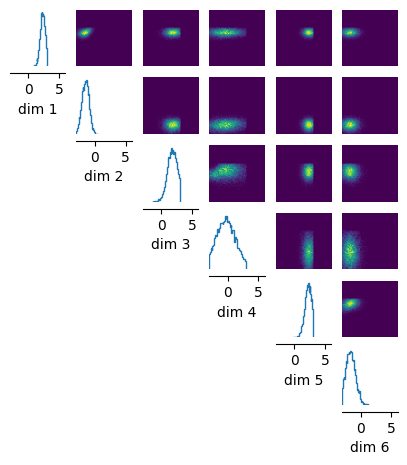

In [40]:
posterior_samples = posterior.sample((10000,), x=true_tensor)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-3, 6], [-3, 6], [-3, 6], [-3, 6], [-3, 6], [-3, 6]], figsize=(5, 5)
)

In [7]:
#Greenberg 19 code...
from sbi.inference import SNPE
rounds = 10
num_sims = 500
x_o = simulator(true_params)
inference = SNPE(prior)
proposal = prior
for _ in range(rounds):
    theta = proposal.sample((num_sims,))
    x = simulator(theta)
    _ = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior().set_default_x(x_o)
    proposal = posterior

ValueError: too many values to unpack (expected 3)